In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip  install subword-nmt
# !pip install nltk
# !pip install torchtext==0.11

In [9]:
# !pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
# !pip install pytorch-nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 90 kB 7.8 MB/s 


In [4]:
import os
root_dir = "/content/drive/My Drive/MADE"
path_do_data = os.path.join(root_dir, 'data.txt')
os.chdir(root_dir)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

In [20]:
from transformers import AutoModel

In [10]:
print(torchtext.__version__)

0.11.0


In [11]:
import train_process
import preprocess_data
import text_score

Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [13]:
train_data, valid_data, test_data, SRC, TRG = preprocess_data.process_dataset(path_do_data)

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500
Unique tokens in source (ru) vocabulary: 9261
Unique tokens in target (en) vocabulary: 6703


Эксперимент 1. Работа с бейзлайном 

Уменьшив количество эпох до 4, получим больший скор, но уровень перевода все равно оставляет желать лучше.

In [15]:
from models import my_network

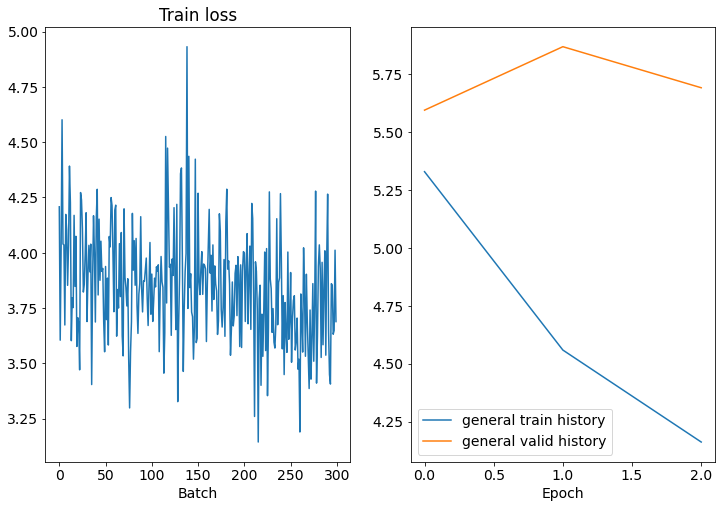

313it [01:43,  3.03it/s]


Epoch: 04 | Time: 1m 44s
	Train Loss: 3.846 | Train PPL:  46.803
	 Val. Loss: 5.253 |  Val. PPL: 191.188


In [16]:
base_model, test_iterator =  train_process.train_model(train_data, valid_data, test_data, SRC, TRG,
                                           my_network, 'base_4_epoch', batch_size=128, n_epochs=4)

In [18]:
text_score.show_results(base_model, test_iterator, TRG)

The model has 14,881,839 trainable parameters


59it [00:04, 12.34it/s]


BLEU: 5.3039426354774575

original: north railway station is located a 30 - minute drive away .
translated: the is is a 5 - minute drive from the and .

original: accommodation will provide you with a tv , air conditioning and a balcony .
translated: a tv , a and and a bathroom with a shower .

original: free wifi is offered .
translated: free wifi throughout the property .

original: there is a 24 - hour front desk at the property .
translated: the property is a . - minute drive away .

original: you can enjoy mountain view .
translated: a a and a and a .



In [19]:
train_process.load_best_model('base_4_epoch', my_network, SRC, TRG, test_iterator)

| Test Loss: 5.212 | Test PPL: 183.373 |


Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9261, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6703, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6703, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

BERT

In [37]:
from models import BERT

In [42]:
train_data, valid_data, test_data, SRC = preprocess_data.process_dataset_bert(path_do_data)

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500
Unique tokens in source (ru) vocabulary: 13665
Unique tokens in target (en) vocabulary: 6703


In [23]:
rubert = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased")

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


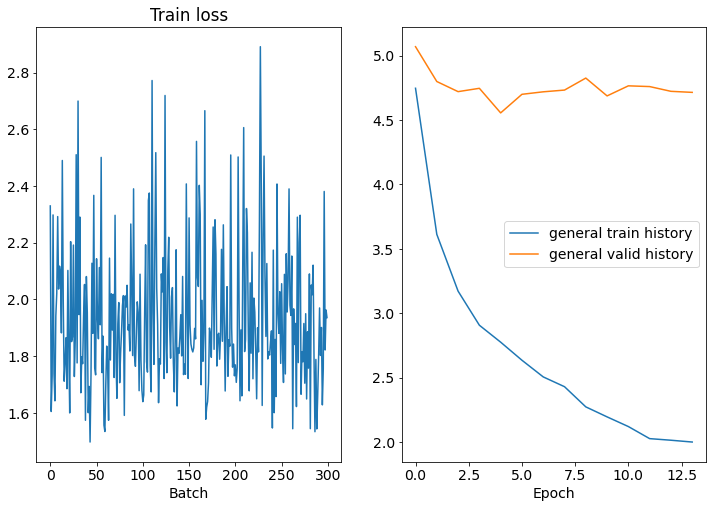

313it [02:57,  1.76it/s]


Epoch: 15 | Time: 3m 0s
	Train Loss: 1.935 | Train PPL:   6.927
	 Val. Loss: 4.808 |  Val. PPL: 122.473


In [43]:
bert_model, test_iterator = train_process.train_model(train_data, valid_data, test_data, SRC, TRG,
                                              BERT, 'bert', batch_size=128, n_epochs=15,
                                              bert=True, bert_model=rubert)

In [45]:
text_score.show_results(bert_model, test_iterator, TRG)

The model has 131,840,559 trainable parameters


59it [00:11,  5.34it/s]


BLEU: 26.414435049822636

original: free public parking is possible on site .
translated: free public parking is available on site .

original: located in casablanca , this air - conditioned apartment features a balcony with city views . the unit is 600 metres from supermarket .
translated: situated 600 metres from , this air - conditioned apartment features a balcony with city views .

original: offering mountain views , elegant rooms and suites are furnished with air conditioning , a wardrobe , in - room safe , a flat - screen cable tv and seating area . electric kettle , refrigerator and minibar are also included .
translated: the elegant , air - conditioned rooms and a wardrobe , a seating area and a minibar .

original: guests can enjoy free access to the on - site fitness room or play pool in the game room .
translated: guests can relax in the on - site fitness room or play billiards in the games room .

original: centrally located in the historic town of , these country - style 